In [1]:
import torch
from torch import nn
from collections import Counter
from itertools import chain
import copy
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
import random

class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.all_letters)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [2]:
class CustomTextDataset(torch.utils.data.Dataset):
    def __init__(self,window_size):
        #self.lines = Read_file("../input/shakespere/shakespeare.txt")
        
        f = open("../input/english-names-dataset/English.txt")
        self.lines = f.read()
        self.all_letters = self.get_uniq_words()
        self.c2ix = None
        self.ix2c = None
        self.window_size = window_size
        self.c2ix = {c: self.all_letters.index(c) for c in self.all_letters}
        #self.c2ix["\n"] = 53-1
        self.ix2c = {i: c  for c , i  in self.c2ix.items()}
        self.long_seq = []
       
        for names in self.lines:
            #for letter in names:
            self.long_seq.append(self.c2ix[names])
       
    def __len__(self):
        return len(self.long_seq)

    def get_uniq_words(self):
        word_counts = Counter(self.lines)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __getitem__(self, idx):
        
        if idx + self.window_size+1 > len(self.long_seq):
            
            diff = idx+self.window_size+1 - len(self.long_seq)
            
            input_sequence = copy.deepcopy(np.concatenate([self.long_seq[idx:],self.long_seq[0:(diff-1)]]))
            
            target_sequence = copy.deepcopy(np.concatenate([self.long_seq[(idx+1):],self.long_seq[0:(diff)]]))
            
        else:
            input_sequence = copy.deepcopy(self.long_seq[idx:(self.window_size+idx)])
            target_sequence = copy.deepcopy(self.long_seq[(idx+1):(self.window_size+idx+1)])
            
       
        return torch.tensor(input_sequence) , torch.tensor(target_sequence)
        
       

In [3]:
window_size = 10
dataset = CustomTextDataset(window_size)
print(dataset.get_uniq_words())
model = Model(dataset)

['\n', 'e', 'n', 'r', 'o', 'a', 'l', 'i', 't', 's', 'd', 'h', 'y', 'c', 'm', 'g', 'u', 'k', 'w', 'b', 'B', 'C', 'D', 'F', 'G', 'H', 'K', 'L', 'M', 'P', 'R', 'S', 'T', 'W', 'A', 'p', 'E', 'f', 'v', 'N', 'O', 'J', 'V', 'I', 'Y', 'x', 'z', 'U', 'Q', 'q', 'j', ' ', 'Z']


In [4]:

def train(dataset, model, batch_size,sequence_length,max_epochs):
    model.train()
    model.cuda()
    losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    state_h, state_c = model.init_state(sequence_length)
    state_h = state_h.cuda()
    state_c = state_c.cuda()
    for epoch in range(max_epochs):
        
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
        
            y_pred, (state_h, state_c) = model(x.type(torch.LongTensor).cuda(), (state_h, state_c))
            
            loss = criterion(y_pred.transpose(1, 2), y.type(torch.LongTensor).cuda())
                             
                             
            state_h, state_c = model.init_state(sequence_length)
                             
            state_h = state_h.cuda()
            state_c = state_c.cuda()
                             
            state_h = state_h.detach()
            state_c = state_c.detach()
                             
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            

        print({ 'epoch': epoch, 'loss': losses[-1] })
    return losses         

In [5]:
losses = train(dataset,model,128,window_size,300)

{'epoch': 0, 'loss': 3.0539915561676025}
{'epoch': 1, 'loss': 2.799452543258667}
{'epoch': 2, 'loss': 2.745736598968506}
{'epoch': 3, 'loss': 2.746486186981201}
{'epoch': 4, 'loss': 2.764843225479126}
{'epoch': 5, 'loss': 2.7388007640838623}
{'epoch': 6, 'loss': 2.6943342685699463}
{'epoch': 7, 'loss': 2.7133235931396484}
{'epoch': 8, 'loss': 2.7207322120666504}
{'epoch': 9, 'loss': 2.6730172634124756}
{'epoch': 10, 'loss': 2.671095132827759}
{'epoch': 11, 'loss': 2.628385066986084}
{'epoch': 12, 'loss': 2.616722822189331}
{'epoch': 13, 'loss': 2.5788514614105225}
{'epoch': 14, 'loss': 2.5341036319732666}
{'epoch': 15, 'loss': 2.4515438079833984}
{'epoch': 16, 'loss': 2.4643714427948}
{'epoch': 17, 'loss': 2.450512409210205}
{'epoch': 18, 'loss': 2.4239604473114014}
{'epoch': 19, 'loss': 2.4098894596099854}
{'epoch': 20, 'loss': 2.3670058250427246}
{'epoch': 21, 'loss': 2.3385839462280273}
{'epoch': 22, 'loss': 2.318629503250122}
{'epoch': 23, 'loss': 2.2476110458374023}
{'epoch': 24, 

In [6]:
def predict(dataset, model, text, next_words=100):
    model.eval()
    model.cpu()
    words = [text]
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.c2ix[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        if dataset.ix2c[word_index] == '\n':
            break
        words.append(dataset.ix2c[word_index])

    return words

In [7]:
num_guesses = 10
for _ in range(num_guesses):
    a = (predict(dataset, model, text=dataset.ix2c[random.randint(1,20)].upper()))
    listToStr = ' '.join(map(str, a))
    print(listToStr)

K e e l a n
G e a v e r s o n
A i t c h i s o n
K i l l e n
L e i t c h
A v e r s o n
U n n i n e
B u r d e t t
E g g b y
R a i n t o n


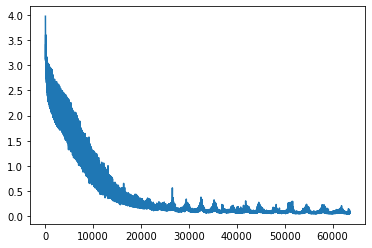

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)

In [9]:
x = len(losses)/(300)
clear = []
for i in range(300):
    clear.append(losses[int(i*x)])

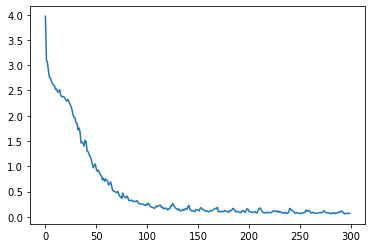

In [10]:


plt.figure()
plt.plot(clear)

In [11]:
torch.save(model.state_dict(), "Name_Generator_Model.pt")